In [1]:
# import torch
# torch.cuda.is_available()

In [2]:
# import torch
# torch.zeros(1).cuda()

In [3]:
# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.layers import Dropout
from keras.layers import Bidirectional, Flatten
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

2023-07-07 07:10:42.596054: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-07 07:10:43.593420: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Fetch Dataset

In [5]:
path = '../Dataset/'

In [6]:
df1 = pd.read_csv(path+'DelhiDataset_named.csv')
df2 = pd.read_csv(path+'KolkataDataset_named.csv')
df = pd.concat([df1,df2]).sample(frac=1).reset_index()
df.dropna(inplace=True)
df.shape , df1.shape
df.rename(columns = {'label':'classLabel'}, inplace = True)

### Visualize Dataset

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23765 entries, 0 to 23766
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       23765 non-null  int64 
 1   Unnamed: 0  23765 non-null  int64 
 2   tweet       23765 non-null  object
 3   classLabel  23765 non-null  object
dtypes: int64(2), object(2)
memory usage: 928.3+ KB


In [8]:
df1.label.value_counts()

Traffic obstruction/car breakdown    4831
Others                               3459
Traffic congestion/heavy traffic     2821
Road closure                         1487
Water logging                        1156
Traffic information/advisory         1001
City program                          416
Accident                              267
Name: label, dtype: int64

In [9]:
df2.label.value_counts()

City program                2150
Roads related congestion    1811
Vehicle breakdown           1636
Closed Avenue               1375
Others                      1103
Road blockage                254
Name: label, dtype: int64

In [10]:
df.classLabel.value_counts()

Traffic obstruction/car breakdown    4831
Others                               4560
Traffic congestion/heavy traffic     2821
City program                         2566
Roads related congestion             1811
Vehicle breakdown                    1636
Road closure                         1487
Closed Avenue                        1375
Water logging                        1156
Traffic information/advisory         1001
Accident                              267
Road blockage                         254
Name: classLabel, dtype: int64

### Merging Similar Data labels as follows
Traffic obstruction/car breakdown = Vehicle breakdown

Traffic congestion/heavy traffic = Roads related congestion

Road closure = Closed Avenue

In [11]:
df.classLabel.replace({'Traffic obstruction/car breakdown':'Vehicle breakdown','Traffic congestion/heavy traffic':'Roads related congestion','Road closure':'Closed Avenue'},inplace=True)

In [12]:
df.classLabel.value_counts()

Vehicle breakdown               6467
Roads related congestion        4632
Others                          4560
Closed Avenue                   2862
City program                    2566
Water logging                   1156
Traffic information/advisory    1001
Accident                         267
Road blockage                    254
Name: classLabel, dtype: int64

[Text(0, 0, 'Vehicle breakdown'),
 Text(1, 0, 'Roads related congestion'),
 Text(2, 0, 'Traffic information/advisory'),
 Text(3, 0, 'City program'),
 Text(4, 0, 'Others'),
 Text(5, 0, 'Closed Avenue'),
 Text(6, 0, 'Water logging'),
 Text(7, 0, 'Accident'),
 Text(8, 0, 'Road blockage')]

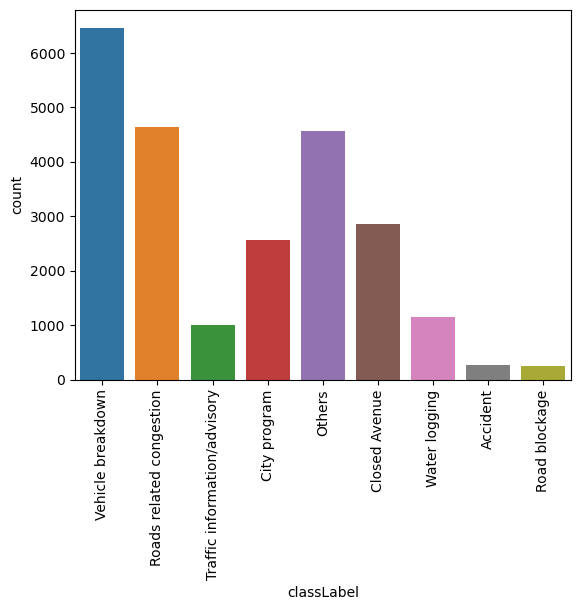

In [13]:
s = sns.countplot(x='classLabel',data=df)
s.set_xticklabels(s.get_xticklabels(),rotation=90)

## Dataset Preprocessing

### Data Cleaning : Stemming and Remove stop words

In [14]:
def print_plot(index):
    example = df[df.index == index][['tweet', 'classLabel']].values[0]
    if len(example) > 0:
        print(example[0])
        print('classLabel:', example[1])

In [15]:
print_plot(10)
print_plot(100)

 A break down DTC bus no DL1PC8183 has been removed in the carriageway running from murti towards park street 
classLabel: Vehicle breakdown
 Obstruction in traffic in the carriageway form Shadipur Depot towards Patel Nagar due to breakdown of a cluster 
classLabel: Vehicle breakdown


In [16]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string

        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing.
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['tweet'] = df['tweet'].apply(clean_text)

In [17]:
df['tweet'] = df['tweet'].str.replace('\d+', '',regex=False)

In [18]:
print_plot(10)
print_plot(100)

break dtc bus dl1pc8183 removed carriageway running murti towards park street
classLabel: Vehicle breakdown
obstruction traffic carriageway form shadipur depot towards patel nagar due breakdown cluster
classLabel: Vehicle breakdown


### Transormation of X data into 'tokenized embedding'

In [19]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 25000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 120
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['tweet'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 11784 unique tokens.


In [20]:
X = tokenizer.texts_to_sequences(df['tweet'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)
X

Shape of data tensor: (23765, 120)


array([[   0,    0,    0, ...,    1,    4,   87],
       [   0,    0,    0, ...,   44,   18,   94],
       [   0,    0,    0, ..., 1087,  184,  837],
       ...,
       [   0,    0,    0, ...,    9,    4,  164],
       [   0,    0,    0, ...,    1,  484,    3],
       [   0,    0,    0, ..., 2855,   49,  718]], dtype=int32)

### Transormation of Y data into 'Label Binarized '

In [21]:
Y = df['classLabel'].values
lb = LabelBinarizer()
y = lb.fit_transform(Y)
y

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### Divide data into Train Test

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(19012, 120) (19012, 9)
(4753, 120) (4753, 9)


## Defining BiLSTM Model

In [23]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

In [50]:

# model = Sequential()
# # model.add(BatchNormalization(input_shape=(10, 128)))
# model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
# # model.add(SpatialDropout1D(0.2))
# model.add(Bidirectional(LSTM(EMBEDDING_DIM, dropout=0.4, recurrent_dropout=0.4, activation='relu', return_sequences=True)))
# model.add(Bidirectional(LSTM(EMBEDDING_DIM, dropout=0.4, recurrent_dropout=0.4, activation='relu',)))
# model.add(Flatten())
# model.add(Dropout(0.4))
# model.add(Dense(64))
# model.add(Dense(y.shape[1], activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(model.summary())
model = Sequential()
# model.add(SpatialDropout1D(0.2))
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(Bidirectional(LSTM(EMBEDDING_DIM, return_sequences=True,dropout=0.2, recurrent_dropout=0.2)))
model.add(Dropout(0.2))
# model.add(Bidirectional(LSTM(EMBEDDING_DIM, dropout=0.2, recurrent_dropout=0.2)))
# model.add(Dropout(0.2))
# model.add(Dense(EMBEDDING_DIM, activation='relu'))
# model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))
adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 100)          2500000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 120, 200)         160800    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 120, 200)          0         
                                                                 
 dense_1 (Dense)             (None, 120, 9)            1809      
                                                                 
Total params: 2,662,609
Trainable params: 2,662,609
Non-trainable params: 0
_________________________________________________________________
None


### Training of model on train Data

In [25]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import keras
st = time.time()
epochs = 50
batch_size = 32

checkpoint_path = '/home/pratik/notebook/tweetProj/TweetProj/SavedModel/BiLSTM-Merged/cp-{epoch:03d}-{loss:0.4f}.hdf5'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    monitor = 'loss',
    mode = min,
    save_best_only = True,
    verbose=1)

history = model.fit(X_train, Y_train, epochs = epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001),cp_callback])

et = time.time()
elapsed_time = et - st
print('Execution time: {:0.0f} seconds'.format(elapsed_time))

model.save('/home/pratik/notebook/tweetProj/TweetProj/SavedModel/BiLSTM-Merged_model.h5')

import pickle
with open('/home/pratik/notebook/tweetProj/TweetProj/SavedModel/BiLSTM-Merged_history', 'wb') as file_pi:
    pickle.dump(history, file_pi)



Epoch 1/50
535/535 [==============================] - ETA: 0s - loss: 0.5329 - accuracy: 0.8338
Epoch 1: loss improved from inf to 0.53287, saving model to /home/pratik/notebook/tweetProj/TweetProj/SavedModel/BiLSTM-Merged/cp-001-0.5329.hdf5
535/535 [==============================] - 187s 331ms/step - loss: 0.5329 - accuracy: 0.8338 - val_loss: 0.1462 - val_accuracy: 0.9637
Epoch 2/50
535/535 [==============================] - ETA: 0s - loss: 0.1411 - accuracy: 0.9607
Epoch 2: loss improved from 0.53287 to 0.14109, saving model to /home/pratik/notebook/tweetProj/TweetProj/SavedModel/BiLSTM-Merged/cp-002-0.1411.hdf5
535/535 [==============================] - 174s 325ms/step - loss: 0.1411 - accuracy: 0.9607 - val_loss: 0.1377 - val_accuracy: 0.9632
Epoch 3/50
535/535 [==============================] - ETA: 0s - loss: 0.1018 - accuracy: 0.9726
Epoch 3: loss improved from 0.14109 to 0.10183, saving model to /home/pratik/notebook/tweetProj/TweetProj/SavedModel/BiLSTM-Merged/cp-003-0.1018.h

## Load Model and History

In [ ]:
# from tensorflow import keras
# model = keras.models.load_model('/home/pratik/notebook/tweetProj/TweetProj/SavedModel/BiLSTM-Merged_model.h5')
# import pickle
# with open(path+'merged_LSTM_history', "rb") as file_pi:
#   history = pickle.load(file_pi)

## Perform on Test Dataset




In [26]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.2f}\n  Accuracy: {:0.2f}%'.format(accr[0],accr[1]*100))

149/149 [==============================] - 9s 61ms/step - loss: 0.1440 - accuracy: 0.9651
Test set
  Loss: 0.14
  Accuracy: 96.51%


## Result Analysis

### Plot Training Testing Accuracy and Loss

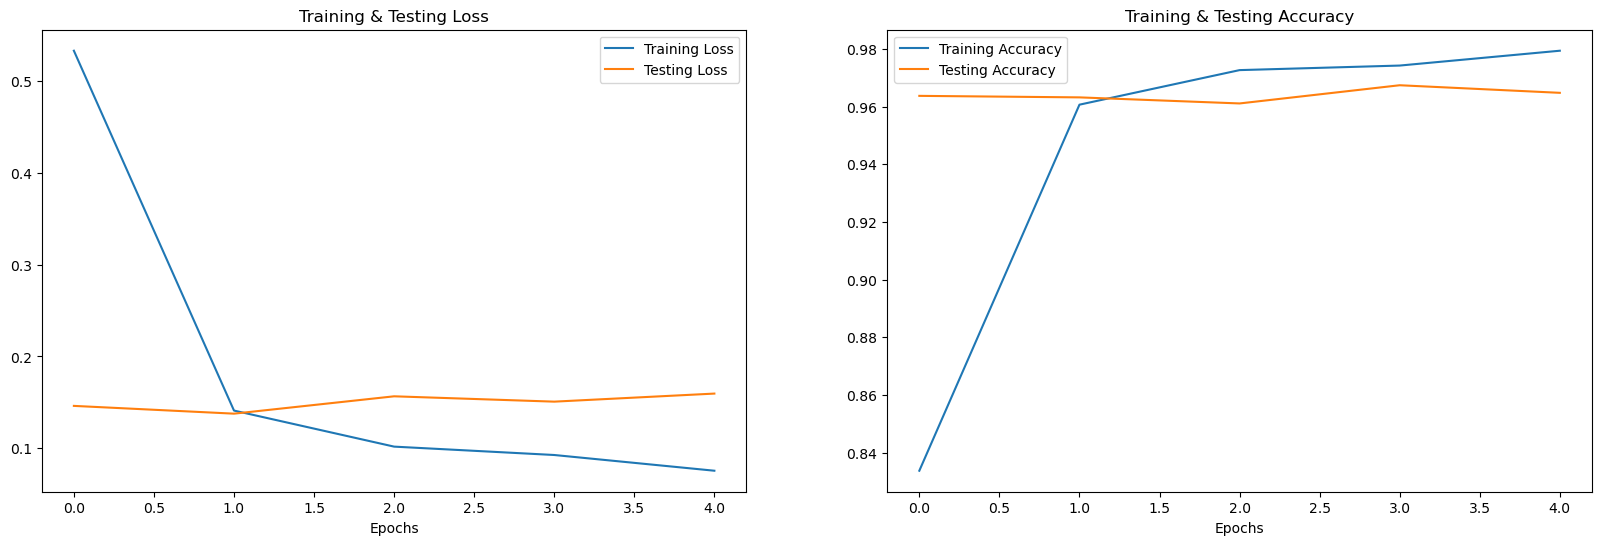

In [27]:
epochList = [i for i in range(len(history.history['loss']))]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochList , train_loss , label = 'Training Loss')
ax[0].plot(epochList , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochList , train_acc , label = 'Training Accuracy')
ax[1].plot(epochList , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

### Prediction of Model on Test Data

In [28]:
pred_test = model.predict(X_test)

149/149 [==============================] - 10s 60ms/step


In [29]:
y_pred = lb.inverse_transform(pred_test)
y_test = lb.inverse_transform(Y_test)

In [30]:
unique, counts = np.unique(y_test, return_counts=True)
print(np.asarray((unique, counts)).T)

[['Accident' '48']
 ['City program' '527']
 ['Closed Avenue' '547']
 ['Others' '929']
 ['Road blockage' '50']
 ['Roads related congestion' '909']
 ['Traffic information/advisory' '199']
 ['Vehicle breakdown' '1332']
 ['Water logging' '212']]


### Plotting Confusion Matrix

<Figure size 3000x1000 with 0 Axes>

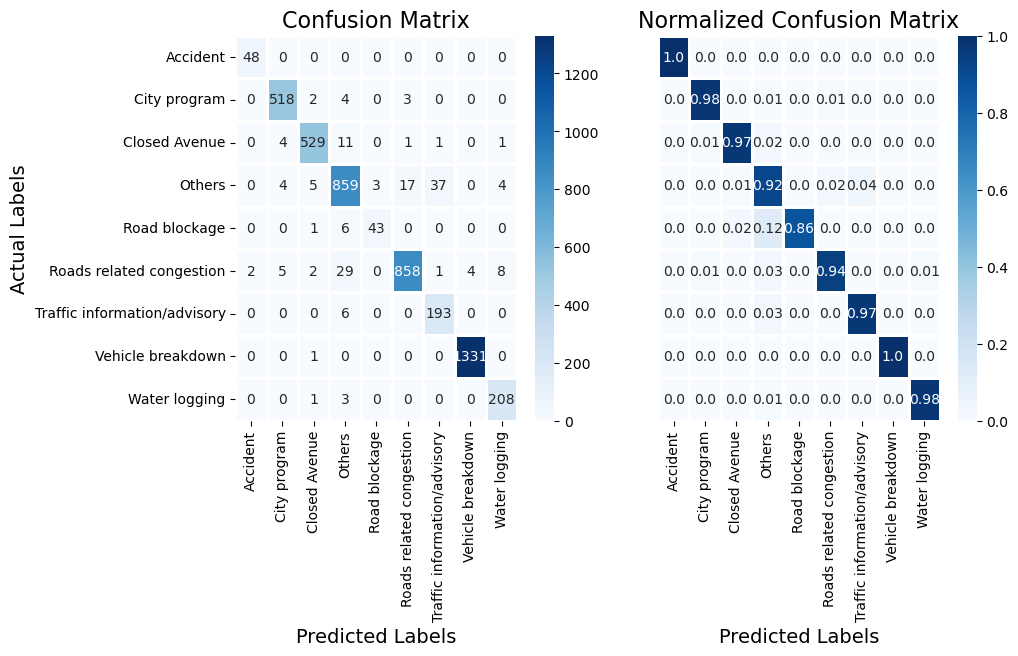

In [31]:
cm = confusion_matrix(y_test, y_pred)
cm1 = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
plt.figure(figsize = (30, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
cm1 = pd.DataFrame(cm1  , columns = [i for i in lb.classes_])

fig , ax = plt.subplots(1,2,figsize=(10,5))
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=2, annot=True, fmt='',ax=ax[0])
ax[0].set_title('Confusion Matrix', size=16)
ax[0].set_xlabel('Predicted Labels', size=14)
ax[0].set_ylabel('Actual Labels', size=14)

sns.heatmap(cm1, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='',ax=ax[1],yticklabels=False)
ax[1].set_title('Normalized Confusion Matrix', size=16)
ax[1].set_xlabel('Predicted Labels', size=14)
plt.show()

In [33]:
print(classification_report(y_test, y_pred))

                              precision    recall  f1-score   support

                    Accident       0.96      1.00      0.98        48
                City program       0.98      0.98      0.98       527
               Closed Avenue       0.98      0.97      0.97       547
                      Others       0.94      0.92      0.93       929
               Road blockage       0.93      0.86      0.90        50
    Roads related congestion       0.98      0.94      0.96       909
Traffic information/advisory       0.83      0.97      0.90       199
           Vehicle breakdown       1.00      1.00      1.00      1332
               Water logging       0.94      0.98      0.96       212

                    accuracy                           0.97      4753
                   macro avg       0.95      0.96      0.95      4753
                weighted avg       0.97      0.97      0.97      4753



### Plotting Confusion Matrix

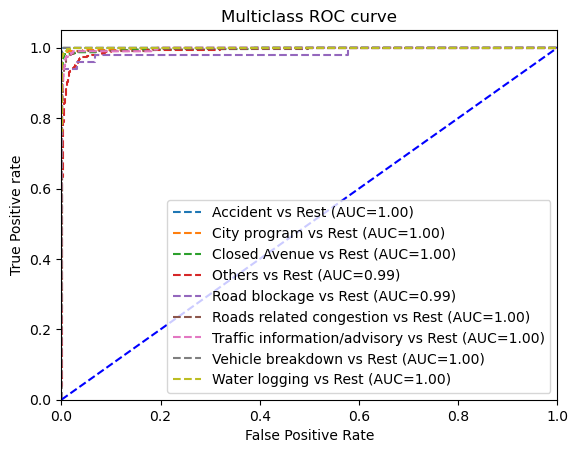

In [34]:
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve,auc

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc_auc = dict()

classes = lb.classes_

for i in range(len(classes)):
    # fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], pred_prob[:,i])
    fpr[i], tpr[i], thresh[i] = roc_curve(Y_test[:,i], pred_test[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # plotting
    plt.plot(fpr[i], tpr[i], linestyle='--',
             label='%s vs Rest (AUC=%0.2f)'%(classes[i],roc_auc[i]))

plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()

## Calculating Evaluation Metric

In [35]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_auc_score
accuracy = accuracy_score(y_test, y_pred)
precision, recall, fscore,_  = score(y_test, y_pred, average='macro')
roc_auc = roc_auc_score(y_test, pred_test,multi_class='ovr')
print('Accuracy, precision, recall, fscore, Roc-AUC')
print('{:.3f},{:.3f},{:.3f},{:.3f},{:.3f}'.format(accuracy,precision,recall,fscore,roc_auc))

Accuracy, precision, recall, fscore, Roc-AUC
0.965,0.948,0.959,0.952,0.996


In [49]:
print('{},{:.0f},{:.4f},{:.4f}'.format(len(history.history['loss']),elapsed_time,train_acc[-1],test_acc[-1]))

5,889,0.9794,0.9648


## Test on Customized Tweet

In [36]:
lb.classes_

array(['Accident', 'City program', 'Closed Avenue', 'Others',
       'Road blockage', 'Roads related congestion',
       'Traffic information/advisory', 'Vehicle breakdown',
       'Water logging'], dtype='<U28')

In [37]:
new_complaint = ['accident on 1 no street']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
print(pred)
print('Label: {}'.format(lb.classes_[np.argmax(pred)]))

1/1 [==============================] - 0s 81ms/step
[[9.9539655e-01 2.3168204e-05 5.4401615e-05 2.5744070e-04 4.3042054e-04
  4.7636963e-04 1.1576047e-05 2.8971834e-03 4.5289478e-04]]
Label: Accident
